In [1]:
%matplotlib notebook
import numpy as np
import cv2 as cv
import matplotlib
from matplotlib import pyplot as plt

In [2]:
def calc_border_mask(img, T_percent):
    """计算得到边缘附近像素点位置的掩模。
    1. 使用拉普拉斯算子计算得到img的边缘图像
    2. 选取边缘图像最大值的T_percent作为阈值对边缘图像做阈值处理，得到一幅二值图像。该二值图像即为结果（亮点即可认为是边缘附近的像素点）
    """
    lap_img = abs(cv.Laplacian(img, -1))
    # lap_kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
    # lap_img = abs(cv.filter2D(img, -1, lap_kernel))
    lap_hist = cv.calcHist([lap_img], [0], None, [256], [0,256])

    T = np.max(lap_img) * T_percent # 阈值取拉普拉斯图像中最大值的xx%
    _, border_mask = cv.threshold(lap_img, T, 255, cv.THRESH_BINARY)
    return border_mask

In [3]:
def max_entropy_1d(hist_normal):
    """
    Implement Kapur-Sahoo-Wong (1d Maximum Entropy) thresholding method.
    paper: J. N. KAPUR, P. K. SAHOO, A. K. C. WONG.
    A New Method for Gray-Level Picture Thresholding Using the Entropy of the Histogram[J].
    COMPUTER VISION, GRAPHICS, AND IMAGE PROCESSING, 1985, 29:273-285.

    Params:
        hist_normal [1d np.array]: 归一化后的图像灰度直方图。
    Return:
        threshold [int]
    """

    # calculate normalized CDF (cumulative density function)
    cdf_normal = hist_normal.cumsum()

    valid_idxs = np.nonzero(hist_normal)[0]
    valid_p_i = hist_normal[valid_idxs]
    H_s_cum = -np.cumsum(valid_p_i * np.log(valid_p_i))

    H_n = H_s_cum[-1]

    max_ent, threshold = 0, 0
    ents = []
    for i in range(len(H_s_cum) - 1): # 忽略最后一个非零点，防止P_s为1导致(1 - P_s)为0
        s = valid_idxs[i]
        P_s = cdf_normal[s]
        H_s = H_s_cum[i]
        total_ent = np.log(P_s * (1 - P_s)) + H_s/P_s + (H_n - H_s)/(1 - P_s)
        
        ents.append(total_ent)
        # find max
        if total_ent > max_ent:
            max_ent, threshold = total_ent, s

    return threshold, max_ent, valid_idxs, ents

由传统一维最大熵分割算法计算出的图像img/panther.jpg的阈值为: 142


<IPython.core.display.Javascript object>


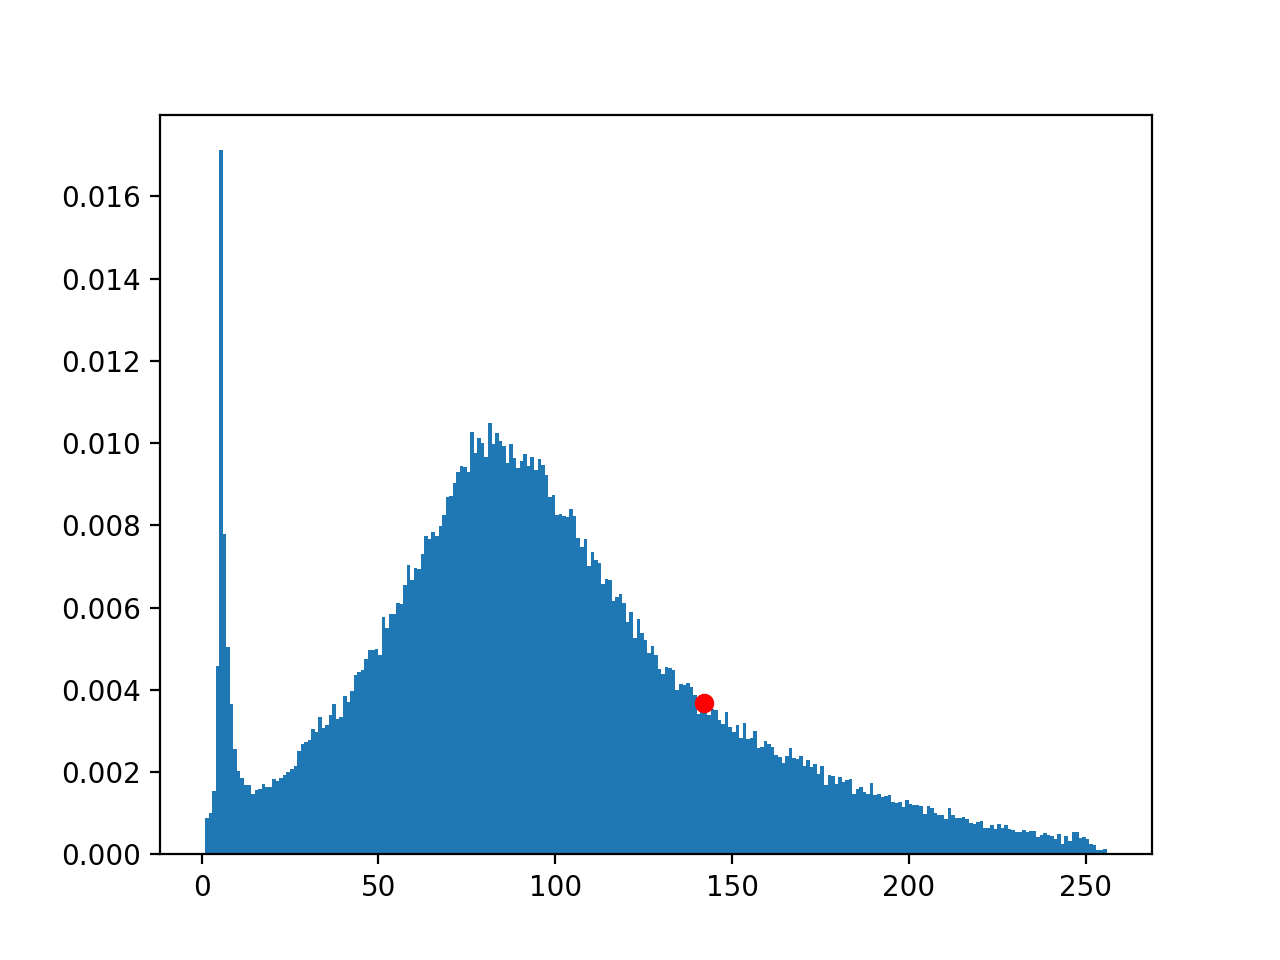

In [4]:
img_name = 'img/panther.jpg'
img = cv.imread(img_name, cv.IMREAD_GRAYSCALE)

hist = cv.calcHist([img], [0], None, [256], [0,256])
hist_normal = cv.normalize(hist.ravel(), None, norm_type=cv.NORM_L1).ravel()

border_mask = calc_border_mask(img, T_percent=0.2)
masked_img = cv.bitwise_and(img, img, mask=border_mask)
masked_img_hist = cv.calcHist([img], [0], border_mask, [256], [0,256])
masked_img_hist_normal = cv.normalize(masked_img_hist.ravel(), None, norm_type=cv.NORM_L1).ravel()

th1, max_ent1, valid_range1, ents1 = max_entropy_1d(hist_normal)
th2, max_ent2, valid_range2, ents2 = max_entropy_1d(masked_img_hist_normal)
# plt.plot(valid_range[:-1], ents)
# plt.plot(threshold, max_ent, 'ro')
# plt.xlabel('gray level')
# plt.ylabel('entropy')
# print(f'计算出阈值为{threshold}')
_, thr_img1 = cv.threshold(img, th1, 255, cv.THRESH_BINARY)
_, thr_img2 = cv.threshold(img, th2, 255, cv.THRESH_BINARY)

# plt.imshow(thr_img, 'gray')
# plt.imshow(border_mask, 'gray')

print(f'由传统一维最大熵分割算法计算出的图像{img_name}的阈值为: {th1}')
plt.hist(img.ravel(), 255, [1,256], density=True)
plt.plot(th1, hist_normal[th1], 'ro')

# print(f'由边缘信息改良后的一维最大熵分割算法计算出的图像{img_name}的阈值为: {th2}')
# plt.hist(masked_img.ravel(), 255, [1,256], density=True)
# plt.plot(th2, masked_img_hist_normal[th2], 'ro')